In [1]:
import os
import pandas as pd
import torch
import torchvision
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models

from torch.autograd import Variable

#Neural Network

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import copy
import argparse

#Ignore Warning

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001


In [18]:
def load_dataset():
    data_dir = 'data/'
    
    data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
    
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
    
    
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
                  for x in ['train', 'val']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    
    class_names = image_datasets['train'].classes
    
    
    return dataloaders, class_names
    
    

In [4]:
dataloaders,class_names = load_dataset()

train_iter = iter(dataloaders)
print(type(train_iter))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

<class 'dict_keyiterator'>
cuda:0


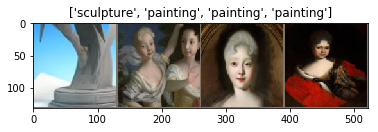

In [5]:
#Function to visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
dataloaders, class_names, dataset_sizes = load_dataset()
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
"""
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            dataloaders, class_names, dataset_sizes = load_dataset()
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
"""

"\ndef train_model(model, criterion, optimizer, scheduler, num_epochs=25):\n    since = time.time()\n\n    best_model_wts = copy.deepcopy(model.state_dict())\n    best_acc = 0.0\n\n    for epoch in range(num_epochs):\n        print('Epoch {}/{}'.format(epoch, num_epochs - 1))\n        print('-' * 10)\n\n        # Each epoch has a training and validation phase\n        for phase in ['train', 'val']:\n            if phase == 'train':\n                scheduler.step()\n                model.train()  # Set model to training mode\n            else:\n                model.eval()   # Set model to evaluate mode\n\n            running_loss = 0.0\n            running_corrects = 0\n\n            # Iterate over data.\n            dataloaders, class_names, dataset_sizes = load_dataset()\n            for inputs, labels in dataloaders[phase]:\n                inputs = inputs.to(device)\n                labels = labels.to(device)\n\n                # zero the parameter gradients\n                optim

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    dataloaders, class_names, dataset_sizes = load_dataset()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
# Custom Model 

class TwoLayerNet(torch.nn.Module):
    def __init__(self, num_classes = 5):
        
        super(TwoLayerNet, self).__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(3,64,3,2,3),
        nn.BatchNorm2d(64),    
        nn.ReLU(True),
        nn.MaxPool2d(3,2,1),
        
        
        #self.linear1 = torch.nn.Linear(D_in, H)
        #self.linear2 = torch.nn.Linear(H, D_out)
        )
        
        

          
        self.layer2 = nn.Sequential(
        nn.Conv2d(64,64,3,2,2),
        #nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.MaxPool2d(3,2,1)
        )
        
        self.fc1 = nn.Linear(5184, num_classes)
        #nn.ReLU(True)
        #self.fc2 = nn.Linear(4096, 4096)
        #nn.ReLU(True)
        #self.fc3 = nn.Linear(4096, num_classes)
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out


In [13]:
model = TwoLayerNet(5).to(device)

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Train the model
total_step = len(dataloaders['train'])
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloaders['train']):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/5], Step [100/1931], Loss: 1.4877
Epoch [1/5], Step [200/1931], Loss: 1.7842
Epoch [1/5], Step [300/1931], Loss: 0.7750
Epoch [1/5], Step [400/1931], Loss: 0.9427
Epoch [1/5], Step [500/1931], Loss: 1.5130
Epoch [1/5], Step [600/1931], Loss: 1.1576
Epoch [1/5], Step [700/1931], Loss: 0.7346
Epoch [1/5], Step [800/1931], Loss: 0.8205
Epoch [1/5], Step [900/1931], Loss: 1.3183
Epoch [1/5], Step [1000/1931], Loss: 0.7009
Epoch [1/5], Step [1100/1931], Loss: 0.4613
Epoch [1/5], Step [1200/1931], Loss: 1.2605
Epoch [1/5], Step [1300/1931], Loss: 1.0980
Epoch [1/5], Step [1400/1931], Loss: 0.5964
Epoch [1/5], Step [1500/1931], Loss: 1.9823
Epoch [1/5], Step [1600/1931], Loss: 0.8512
Epoch [1/5], Step [1700/1931], Loss: 0.7045
Epoch [1/5], Step [1800/1931], Loss: 1.9204
Epoch [1/5], Step [1900/1931], Loss: 1.4187
Epoch [2/5], Step [100/1931], Loss: 0.9998
Epoch [2/5], Step [200/1931], Loss: 1.4129
Epoch [2/5], Step [300/1931], Loss: 1.7894
Epoch [2/5], Step [400/1931], Loss: 0.5275
E

In [17]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
#torch.save(model.state_dict(), 'model.ckpt')

ValueError: too many values to unpack (expected 2)